

> Credit for the applied procedure : https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch



#Library and Dictionary import


In [111]:
!nvidia-smi

Tue May 17 06:53:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |   2825MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
import sys
sys.path.append('/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Library/')
!pip install --upgrade pythainlp
!pip install torchinfo
!pip install torchviz

In [114]:
from data_processing_non import dictionary

In [115]:
!pip install torchinfo
!pip install torchviz

In [116]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random


import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms, models
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary

from sklearn.model_selection import train_test_split

In [117]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [118]:
num_of_vocab = len(dictionary.stoi)
num_of_vocab

7803

# Dataset and dataloader


In [119]:
dataframe_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Data/archive/"

In [120]:
train_captions_files = [dataframe_path+"captions_train.csv",
                  "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/cross-linguistics/train_chinese_to_thai.csv"]
val_captions_files = [dataframe_path+"captions_val.csv"]
test_captions_files = [dataframe_path+"captions_test.csv"]

In [121]:
train = pd.read_csv(dataframe_path+"captions_train.csv")
test = pd.read_csv(dataframe_path+"captions_test.csv")
val = pd.read_csv(dataframe_path+"captions_val.csv")
len(train), len(test), len(val)

(28315, 6070, 6070)

In [122]:
train.head()

,image,caption,caption_th,tokenized_caption_th
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,เด็กในชุดสีชมพูกำลังปีนขึ้นบันไดตรงทางเข้า,"['<start>', 'เด็ก', 'ใน', 'ชุด', 'สีชมพู', 'กำ..."
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,เด็กผู้หญิงกำลังเข้าไปในอาคารไม้,"['<start>', 'เด็กผู้หญิง', 'กำลัง', 'เข้าไป', ..."
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,เด็กหญิงตัวเล็ก ๆ กำลังปีนเข้าไปในโรงละครไม้,"['<start>', 'เด็กหญิง', 'ตัวเล็ก', ' ', 'ๆ', '..."
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,เด็กหญิงตัวเล็ก ๆ กำลังปีนบันไดไปที่โรงละครของเธอ,"['<start>', 'เด็กหญิง', 'ตัวเล็ก', ' ', 'ๆ', '..."
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,เด็กหญิงตัวเล็ก ๆ ในชุดสีชมพูกำลังเข้าไปในกระท...,"['<start>', 'เด็กหญิง', 'ตัวเล็ก', ' ', 'ๆ', '..."


In [123]:
class FlickrDataset(Dataset):
    def __init__(self, 
                 captions_files, 
                 image_dir = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/00 Data/archive/Images/", 
                 transform=None,
                 dictionary=dictionary,
                 test = False):
      
      self.image_dir = image_dir

      if type(captions_files) is str:
        self.dfs = pd.read_csv(captions_files)
        self.dfs = [self.df]
      elif type(captions_files) is list:
        for i in range(len(captions_files)):
          if  type(captions_files[i]) is str:
            captions_files[i] = pd.read_csv(captions_files[i])
        self.dfs = captions_files

      self.transform = transform
      self.test = test
      self.img_id = []
      self.img = {}
      self.caption = {}
      self.dictionary = dictionary

      unique_image = self.dfs[0]['image'].unique()

      for i in tqdm(range(len(unique_image))):
        img_id = unique_image[i]
        if img_id in self.caption:
          continue
        self.img_id.append(img_id)
        self.caption[img_id] = []
      
      for df in self.dfs:

        for i in tqdm(range(len(df))):
          img_id = df.iloc[i]['image']
          caption = df.iloc[i]['tokenized_caption_th']

          caption = caption[1:-1]
          caption = caption.split(",")
          caption = [word[1:].replace("'", "") for word in caption] 
          caption = self.dictionary.numericalize(caption)
          caption = torch.tensor(caption)

          self.caption[img_id].append(caption)
        
        
    def __len__(self):
      return len(self.img_id)
    
    def __getitem__(self, idx): 

      img_id = self.img_id[idx]
      if img_id not in self.img:
        img_path = os.path.join(self.image_dir, img_id)
        img = Image.open(img_path).convert("RGB")
        self.img[img_id] = img

      img = self.img[img_id]
      caption = random.choice(self.caption[img_id])
      if self.transform is not None:
        transformed_img = self.transform(img)
      
      if not self.test:
        return transformed_img, caption, img

      return transformed_img, caption, img, self.caption[img_id]
      

In [124]:
# Collate_fn for calling to transform a batch before return. 
class Collate_fn:
  def __init__(self, pad_value, batch_first=False):
    self.pad_value = pad_value       
    self.batch_first = batch_first    
        
  def __call__(self, batch):
    transformed_imgs = [item[0].unsqueeze(0) for item in batch]
    transformed_imgs = torch.cat(transformed_imgs, dim=0)    
        
    captions = [item[1] for item in batch]   
    captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)

    img = [item[2] for item in batch]
    
    if len(batch[0]) > 3:
      return transformed_imgs, captions, img, [item[3] for item in batch]

    return transformed_imgs, captions, img

In [125]:
image_size = 299
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])


In [126]:
batch_size = 32
train_flickrdataset = FlickrDataset(transform = train_transform, captions_files = train_captions_files)
train_flickrdataloader = torch.utils.data.DataLoader( train_flickrdataset, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 

val_flickrdataset = FlickrDataset(transform = val_transform, captions_files = val_captions_files)
val_flickrdataloader = torch.utils.data.DataLoader( val_flickrdataset, 
                                                batch_size=batch_size, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 

test_flickrdataset = FlickrDataset(transform = val_transform, captions_files = test_captions_files, test = True)
test_flickrdataloader = torch.utils.data.DataLoader( test_flickrdataset, 
                                                batch_size=batch_size,
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 

  0%|          | 0/5663 [00:00<?, ?it/s]

  0%|          | 0/28315 [00:00<?, ?it/s]

  0%|          | 0/28315 [00:00<?, ?it/s]

  0%|          | 0/1214 [00:00<?, ?it/s]

  0%|          | 0/6070 [00:00<?, ?it/s]

  0%|          | 0/1214 [00:00<?, ?it/s]

  0%|          | 0/6070 [00:00<?, ?it/s]

In [127]:
transformed_imgs, captions, imgs = next(iter(train_flickrdataloader))

In [128]:
transformed_imgs, captions, imgs = next(iter(val_flickrdataloader))

In [129]:
transformed_imgs, captions, imgs, _  = next(iter(test_flickrdataloader))

#Model 

In [130]:
resnet = models.resnet50()
#summary(resnet, (1, 3, image_size, image_size))

##Encoder

The architecture of the encoder is Resnet50(Without head and global adaptive pooling)

In [131]:
def freeze_layer(layer):
  for param in layer.parameters():
    param.requires_grad_(False)
  return layer

In [132]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    resnet = models.resnet50(pretrained = True)
    resnet = freeze_layer(resnet)
    resnet = list(resnet.children())[:-2]
    self.resnet = nn.Sequential(*resnet)

  def forward(self, image):
    features = self.resnet(image)
    features = features.permute(0, 2, 3, 1)
    features =  features.view(features.size(0), -1, features.size(-1))
    #print(features.shape)
    return features

In [133]:
encoder = Encoder()
summary(encoder, (1, 3, image_size, image_size))

Layer (type:depth-idx)                        Output Shape              Param #
Encoder                                       --                        --
├─Sequential: 1-1                             [1, 2048, 10, 10]         --
│    └─Conv2d: 2-1                            [1, 64, 150, 150]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 150, 150]         (128)
│    └─ReLU: 2-3                              [1, 64, 150, 150]         --
│    └─MaxPool2d: 2-4                         [1, 64, 75, 75]           --
│    └─Sequential: 2-5                        [1, 256, 75, 75]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 75, 75]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 75, 75]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 75, 75]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 38, 38]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 38, 38]       

##Attention


The architecture of the attention is add(hx, fx)-linear-tanh-softmax.


While hx is hidden_state-linear and fx is feature-linear.


In [134]:
class Attention(nn.Module):
  def __init__(self, encoder_dim, decoder_dim, attention_dim):
    super().__init__()
    self.attention_dim = attention_dim
    self.lin_features = nn.Linear(encoder_dim, attention_dim)
    self.lin_hidden = nn.Linear(decoder_dim, attention_dim)
    self.attention_layer = nn.Linear(attention_dim, 1)

  def forward(self, features, hidden_states):
    lined_features = self.lin_features(features) 
    
    lined_hidden_states = self.lin_hidden(hidden_states)
    lined_hidden_states = torch.permute(lined_hidden_states, (1, 0, 2))

    combined_values = torch.tanh(lined_features+lined_hidden_states)
    combined_values = self.attention_layer(combined_values)
    combined_values = combined_values.squeeze(2)
    alpha = F.softmax(combined_values, dim = 1)

    context = features*alpha.unsqueeze(2) 
    context = context.sum(dim=1)

    return alpha, context

In [135]:
attention = Attention(encoder_dim = 2048, decoder_dim = 10, attention_dim = 100)
summary(attention, [(10, 101, 2048), (1, 10, 10)])

Layer (type:depth-idx)                   Output Shape              Param #
Attention                                --                        --
├─Linear: 1-1                            [10, 101, 100]            204,900
├─Linear: 1-2                            [1, 10, 100]              1,100
├─Linear: 1-3                            [10, 101, 1]              101
Total params: 206,101
Trainable params: 206,101
Non-trainable params: 0
Total mult-adds (M): 2.05
Input size (MB): 8.27
Forward/backward pass size (MB): 0.82
Params size (MB): 0.82
Estimated Total Size (MB): 9.92

##Decoder


In [136]:
# 1. embed caption 
# 2. h0 initial state by linear(feature)
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob = 0.3):
    super().__init__()
    self.vocab_size = vocab_size 
    self.attention_dim = attention_dim
    self.decoder_dim = decoder_dim

    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.attention = Attention(encoder_dim,decoder_dim,attention_dim)


    self.init_h_layer = nn.Linear(encoder_dim, decoder_dim)

    self.gru = nn.GRU(embed_size+encoder_dim, decoder_dim, batch_first = True)
    self.f_beta = nn.Linear(decoder_dim, encoder_dim)
    self.fcn = nn.Linear(decoder_dim,vocab_size)
    self.drop = nn.Dropout(drop_prob)

  def forward(self, features, captions):
    h = self.init_h(features)

    embed_caption = self.embedding(captions)
    sentence_length = embed_caption.shape[1]
    batch_size = features.shape[0]
    num_features = features.shape[1]

    preds = torch.zeros(batch_size, sentence_length-1, self.vocab_size).to(device)
    alphas = torch.zeros(batch_size, sentence_length-1, num_features).to(device)

    for i in range(sentence_length-1):
      alpha, context = self.attention(features, h)
      gru_input = torch.cat((embed_caption[:,i], context), dim = 1).unsqueeze(1)
      
      output, h = self.gru(gru_input, h)
      output = output.squeeze(1)
      output = self.fcn(self.drop(output))
      preds[:,i] = output
      alphas[:,i] = alpha 

    return preds, alphas

  def generate_text(self, features, max_length = 20):
    h = self.init_h(features)

    batch_size = features.shape[0]
    num_features = features.shape[1]

    preds = torch.zeros(batch_size, max_length).to(device)
    alphas = torch.zeros(batch_size, max_length, num_features).to(device)

    caption = torch.ones(batch_size, 1, dtype = torch.int).to(device)

    for i in range(max_length):
      alpha, context = self.attention(features, h)
      caption = self.embedding(caption)
      caption = caption.squeeze(1)

      gru_input = torch.cat((caption, context), dim = 1).unsqueeze(1)

      output, h = self.gru(gru_input, h)
      output = output.squeeze(1)
      output = self.fcn(self.drop(output))
      caption = torch.argmax(output, dim = 1)

      preds[:,i] = caption
      alphas[:,i] = alpha 

    text_output = []
    for i in range(batch_size):
      string = ["<start>"]
      for j in range(max_length):
        temp = dictionary.itos[preds[i][j].item()]
        string.append(temp)
        if temp == "<PAD>" or temp == "<end>":
          break
      text_output.append(string)

    return text_output, alpha

  def init_h(self, features):
    mean_features = features.mean(dim = 1)
    h = self.init_h_layer(mean_features)
    h = h.unsqueeze(0)
    return h

In [137]:
decoderrnn = DecoderRNN(150, 6771, 256, 2048, 512).to(device)

In [138]:
summary(decoderrnn)

Layer (type:depth-idx)                   Param #
DecoderRNN                               --
├─Embedding: 1-1                         1,015,650
├─Attention: 1-2                         --
│    └─Linear: 2-1                       524,544
│    └─Linear: 2-2                       131,328
│    └─Linear: 2-3                       257
├─Linear: 1-3                            1,049,088
├─GRU: 1-4                               4,165,632
├─Linear: 1-5                            1,050,624
├─Linear: 1-6                            3,473,523
├─Dropout: 1-7                           --
Total params: 11,410,646
Trainable params: 11,410,646
Non-trainable params: 0

In [139]:
features = torch.randn(32,100,2048).to(device)
captions = torch.ones(32, 100, dtype=torch.int).to(device)
#decoderrnn.generate_text(features)

In [140]:
h0 = torch.ones(1, 5, 2)

In [141]:
rnn = nn.GRU(1, 2, 1, batch_first = True)
input = torch.randn(5, 3, 1)
output, h0 = rnn(input, h0)
output.shape, h0.shape

(torch.Size([5, 3, 2]), torch.Size([1, 5, 2]))

In [142]:
h0

tensor([[[-0.2986, -0.0603],
         [-0.1616,  0.5082],
         [-0.2874,  0.3348],
         [-0.2749,  0.2059],
         [-0.0484,  0.6505]]], grad_fn=<StackBackward0>)

##Encoder Decoder

In [143]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        preds, alphas = self.decoder(features, captions)
        return preds, alphas

    def generate_text(self, images):
        features = self.encoder(images)
        text_output, alpha = self.decoder.generate_text(features)
        return text_output, alpha


In [144]:
embed_size=300
vocab_size = len(dictionary.stoi)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [145]:
device

'cuda'

In [146]:
encoder = EncoderDecoder(embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim).to(device)
images = torch.randn(32,3,299,299).to(device)
captions = torch.ones(32, 20, dtype = torch.int).to(device)
with torch.no_grad():
  x = encoder(images, captions)

##Hyperparameter initiation

In [147]:
embed_size=300
vocab_size = len(dictionary.stoi)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 1e-3

In [148]:
model = EncoderDecoder(embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim).to(device)

In [149]:
criterion = nn.CrossEntropyLoss(ignore_index=dictionary.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 0, min_lr = 1e-7)

##Training

In [150]:
num_epoch = 25
print_every = 50

In [151]:
train_losses = [] 
val_losses = [] 
lrs = []
min_val_loss = float('inf')

In [152]:
best_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/baseline_attention_cross_ling_model_state.pth"

def save_model(model,num_iteration):
    model_state = {
        'num_epochs':num_iteration,
        'embed_size':embed_size,
        'vocab_size':vocab_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }
    torch.save(model_state, best_path)
    print(best_path)

In [153]:
best_val = float('inf')

for i in tqdm(range(num_epoch)): 

  model.train()
  total_train_loss = 0 
  count = 0 

  for transformed_img, captions, _ in tqdm(train_flickrdataloader):
  
    optimizer.zero_grad()
    transformed_img, captions = transformed_img.to(device), captions.to(device)

    outputs,attentions = model(transformed_img, captions)
    captions = captions[:, 1:]
    train_loss = criterion(outputs.reshape(-1, vocab_size), captions.reshape(-1))

    train_loss.backward()
    total_train_loss += train_loss
    count+= 1
    optimizer.step()

  total_train_loss /= count
  scheduler.step(total_train_loss)
  lrs.append(optimizer.param_groups[0]['lr'])
  train_losses.append(train_loss.item())

  model.eval()
  total_val_loss = 0 
  count = 0 
  with torch.no_grad():
    for transformed_img, captions, img in val_flickrdataloader:
      transformed_img, captions = transformed_img.to(device), captions.to(device)
      captions = captions[:,1:]
      outputs, attentions = model(transformed_img, captions)
      captions = captions[:, 1:]
      val_loss = criterion(outputs.reshape(-1, vocab_size), captions.reshape(-1))
      total_val_loss += val_loss
      count += 1

    total_val_loss /= count
    val_losses.append(total_val_loss.item())
    if val_loss < best_val:
      save_model(model, i)

    transformed_img, captions, img = next(iter(val_flickrdataloader)) 
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)

    print("LR : ", lrs[-1],"Train loss : ", total_train_loss, "Val loss : ",total_val_loss)
    for i in range(5):
      print("Real: ", "".join([ dictionary.itos[i] for i in captions[i].cpu().detach().numpy() ]))
      print("Prodicted: ", "".join(text_output[i]))
      plt.imshow(img[i])
      plt.show()
    print()

  

Output hidden; open in https://colab.research.google.com to view.

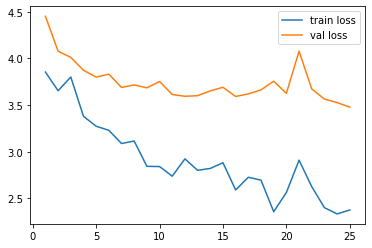

In [154]:
plt.plot(np.arange(1, len(train_losses)+1), train_losses, label='train loss') 
plt.plot(np.arange(1, len(val_losses)+1), val_losses, label='val loss') 
plt.legend()
plt.show()

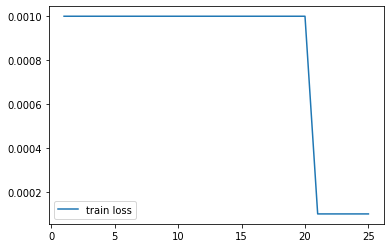

In [155]:
plt.plot(np.arange(1, len(lrs)+1), lrs, label='train loss') 
plt.legend()
plt.show()

##Testing

In [156]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu

In [157]:
best_path = "/content/drive/MyDrive/CP-Eng-3rd-year/Pattern Recog/Project/01 Model/Anon/baseline_attention_cross_ling_model_state.pth"
best = torch.load(best_path)
model.load_state_dict(best['state_dict'])

<All keys matched successfully>

In [158]:
def show_image_for_testing(all_captions, text_output, img):
  print()
  print("Predicted: ", "".join(text_output))
  for caption in all_captions:
    caption = [dictionary.itos[token.item()] for token in caption]
    reference.append(caption)
    print("Real: ", "".join(caption))
  print(sentence_bleu(reference, text_output))
  plt.imshow(img)
  plt.show()

In [162]:
avg_bleu_score = 0
count = 0
max_count = 10
count = len(test)
model.eval()

ref = list()
predict = list()

val_flickrdataset = FlickrDataset(transform = val_transform, captions_files = val_captions_files, test = True)
val_flickrdataloader = torch.utils.data.DataLoader( val_flickrdataset, 
                                                batch_size=batch_size, 
                                                pin_memory=True, 
                                                collate_fn = Collate_fn(pad_value=0, batch_first = True)) 


with torch.no_grad():
  for transformed_img, captions, img, all_captions in tqdm(val_flickrdataloader):
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)
    for i in range(len(all_captions)):
      reference = []
      for caption in all_captions[i]:
        reference.append([dictionary.itos[token.item()] for token in caption if token not in [0, 1, 2, 3]])
      candidate = [ token for token in text_output[i] if dictionary.stoi[token] not in [0, 1, 2, 3]]

      ref.append(reference)
      predict.append(candidate)

      bleu = sentence_bleu(reference, candidate)
      if bleu <0.2:
        show_image_for_testing(all_captions[i], text_output[i], img[i])


Output hidden; open in https://colab.research.google.com to view.

In [163]:
print("Avg VAL BLEU Score:", corpus_bleu(ref, predict))

Avg VAL BLEU Score: 0.1731400129790296


In [164]:
avg_bleu_score = 0
count = 0
max_count = 10
count = len(test)
model.eval()

ref = list()
predict = list()


with torch.no_grad():
  for transformed_img, captions, img, all_captions in tqdm(test_flickrdataloader):
    transformed_img, captions = transformed_img.to(device), captions.to(device)
    text_output, _ = model.generate_text(transformed_img)
    for i in range(len(all_captions)):
      reference = []
      for caption in all_captions[i]:
        reference.append([dictionary.itos[token.item()] for token in caption if token not in [0, 1, 2, 3]])
      candidate = [ token for token in text_output[i] if dictionary.stoi[token] not in [0, 1, 2, 3]]

      ref.append(reference)
      predict.append(candidate)

      bleu = sentence_bleu(reference, candidate)
      if bleu <0.2:
        show_image_for_testing(all_captions[i], text_output[i], img[i])


Output hidden; open in https://colab.research.google.com to view.

In [165]:
ref[0], predict[0]

([['หมา', 'ดำ', 'วิ่งเล่น', 'เซิร์ฟ'],
  ['ห้อง',
   'แล็บ',
   'สี',
   'ดำ',
   'ที่',
   'มี',
   'ป้าย',
   'ห้อย',
   'อยู่',
   'ใน',
   'น้ำ'],
  ['หมา', 'กระเด็น', 'น้ำ'],
  ['หมา', 'ดำ', 'วิ่ง', 'ผ่าน', 'น้ำ'],
  ['นี่',
   'คือ',
   'สุนัข',
   'สี',
   'ดำ',
   'ที่',
   'กระเด็น',
   'ลง',
   'ไป',
   'ใน',
   'น้ำ']],
 [' ',
  'สุนัข',
  'สี',
  'ดำ',
  'และ',
  'สี',
  'ขาว',
  'กำลัง',
  'เล่น',
  'อยู่',
  'ใน',
  'น้ำ'])

In [166]:
print("Avg TEST BLEU Score:", corpus_bleu(ref, predict))

Avg TEST BLEU Score: 0.17038942315219502



Predicted:  <start> สุนัขสีดำและสีขาวกำลังเล่นอยู่ในน้ำ<end>
Real:  <start>หมาดำวิ่งเล่นเซิร์ฟ<end>
Real:  <start>ห้องแล็บสีดำที่มีป้ายห้อยอยู่ในน้ำ<end>
Real:  <start>หมากระเด็นน้ำ<end>
Real:  <start>หมาดำวิ่งผ่านน้ำ<end>
Real:  <start>นี่คือสุนัขสีดำที่กระเด็นลงไปในน้ำ<end>
0.2658483576665877


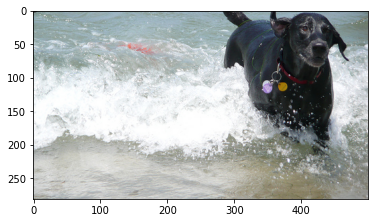


Predicted:  <start>สุนัขสีดำกำลังวิ่งอยู่ในหญ้า<end>
Real:  <start>สุนัขสีดำถือของเล่นสีเขียวเข้าปากขณะเดินผ่านหญ้า<end>
Real:  <start>หมาดำกำลังแบกอะไรบางอย่างอยู่บนพื้นหญ้า<end>
Real:  <start>สุนัขสีดำมีของเล่นสีน้ำเงินอยู่ในปาก<end>
Real:  <start>สุนัขในหญ้าที่มีสิ่งของสีน้ำเงินอยู่ในปากของเขา<end>
Real:  <start>สุนัขสีดำเปียกกำลังแบกของเล่นสีเขียวอยู่บนพื้นหญ้า<end>
0.35979535642857696


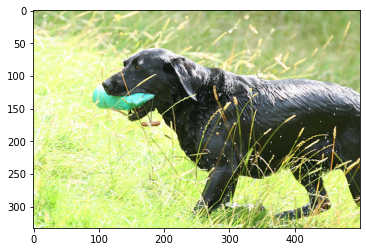


Predicted:  <start> ผู้คนยืนอยู่บนถนนในเมือง<end>
Real:  <start>ผู้ชายยืนอยู่หน้าตึกระฟ้า<end>
Real:  <start>ชายคนหนึ่งยืนอยู่หน้าตึกระฟ้า<end>
Real:  <start>ชายคนหนึ่งยืนอยู่หน้าอาคารสูงมาก<end>
Real:  <start>ข้างหลังชายเสื้อแดงมีตึกระฟ้าขนาดใหญ่<end>
Real:  <start>มีตึกระฟ้าอยู่ไกลๆ โดยมีชายคนหนึ่งเดินอยู่หน้ากล้อง<end>
0.4854917717073234


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


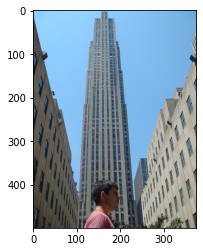


Predicted:  <start> ชายคนหนึ่งยืนอยู่บนถนนในเมือง<end>
Real:  <start>คนงานก่อสร้างสองคนนั่งพักบนคาน<end>
Real:  <start>คนงานก่อสร้างสองคนนั่งอยู่ที่ด้านข้างของอาคาร<end>
Real:  <start>คนงานก่อสร้างสองคนนั่งอยู่บนไอบีม<end>
Real:  <start>คนงานก่อสร้างสองคนนั่งบนคานเหล็ก<end>
Real:  <start>ชายสองคนพักจากการก่อสร้าง<end>
0.4617366309441026


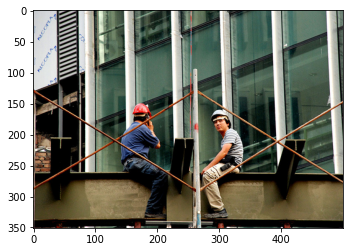


Predicted:  <start>สุนัขวิ่งไปตามชายหาด<end>
Real:  <start>สุนัขสีอ่อนวิ่งบนชายหาด<end>
Real:  <start>หมาน้อยสีเหลืองวิ่งบนชายหาด<end>
Real:  <start>สุนัขผิวสีแทนวิ่งบนหาดทราย<end>
Real:  <start>สุนัขสีขาวกำลังวิ่งไปตามชายหาดหิน<end>
Real:  <start>สุนัขสีน้ำตาลอ่อนวิ่งไปตามชายหาด<end>
0.6129752413741056


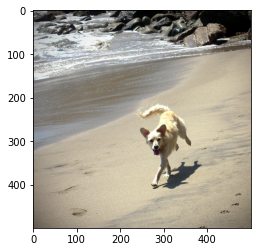

In [167]:
transformed_img, captions, img, all_captions = next(iter(test_flickrdataloader))
transformed_img, captions = transformed_img.to(device), captions.to(device)
text_output, _ = model.generate_text(transformed_img)
for i in range(5):
  reference = []
  show_image_for_testing(all_captions[i], text_output[i], img[i])
  